# Predicting

Using our three objects, we can now predict the transitions.

In [1]:
import sys
sys.path.append("../")

from MapSci.papers import papers
from MapSci.research_space import research_space
from MapSci.entities import entities
import MapSci.agg as agg
import MapSci.predict as pr

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import numpy as np

As in [before](https://github.com/franciscogaluppo/science-of-science/blob/master/examples/2\)%20Research%20Space.ipynb), we will first load our papers object using the 'lattes_categories' key. We will also initialize our research space object with the same key, passing our papers as a parameter, and computing the spaces for our timeframe of interest.

In [2]:
pp = papers("lattes_categories")
maps = research_space("lattes_categories", pp)
maps.compute(1999, 2013)

freq = maps.phi["frequentist(1999, 2013, 0.1)"][0]
embe = maps.phi["embedding(1999, 2013, 0.1, 200)"][0]
spaces = [freq, embe]

frequentist(1999, 2013, 0.1)
embedding(1999, 2013, 0.1, 200)


The scientists entities object

In [3]:
presence = pp.presence(2011, 2013)
indices = maps.phi["frequentist(1999, 2013, 0.1)"][1]
scientists = entities(presence, indices)

And the aggregation:

In [4]:
inst, st = agg.get_insts(scientists.set, "../dataset/lattes/pesquisadores.csv", sep=";sep;")

xi = agg.aggregate(presence[1], inst)
presence_inst = pp.presence(2011, 2013, x=xi)
institutions = entities(presence_inst, indices)

xs = agg.aggregate(presence[1], st)
presence_st = pp.presence(2011, 2013, x=xs)
states = entities(presence_st, indices)

To predict is extremely easy. Just call a function! These are the top 10 predictions for Alberto Laender, one of the professors in our computer science department.

In [5]:
# Laender
scientists.predict(9089204821424223, freq, 'inactive-active')[:10]

[(0.29416300773842985, 'logic'),
 (0.2734763841298093, 'computer networks and communications'),
 (0.2547066548787358, 'computer science (miscellaneous)'),
 (0.2529282655412077, 'management information systems'),
 (0.20083009839195734, 'media technology'),
 (0.19999059653526374, 'signal processing'),
 (0.18973653887311284, 'human-computer interaction'),
 (0.18272015145170095, 'computer vision and pattern recognition'),
 (0.18087997180920903, 'control and optimization'),
 (0.17409435366492873, 'e-learning')]

To check how good the predictions are, we need to prepare a ground truth. Note that this is as simple as checking the presence matrix for the following years.

In [6]:
ground_truth = pp.presence(2014, 2016)
scientists_future = entities(ground_truth, indices)

xs = agg.aggregate(ground_truth[1], st)
presence_st_future = pp.presence(2014, 2016, x=xs)
states_future = entities(presence_st_future, indices)

xi = agg.aggregate(ground_truth[1], inst)
presence_inst_future = pp.presence(2014, 2016, x=xi)
institutions_future = entities(presence_inst_future, indices)

Below we can see the accuracy (as measured by the AUROC) for states. Not the best.

1 out of 1 scores couldn't be computed.


ValueError: zero-size array to reduction operation minimum which has no identity

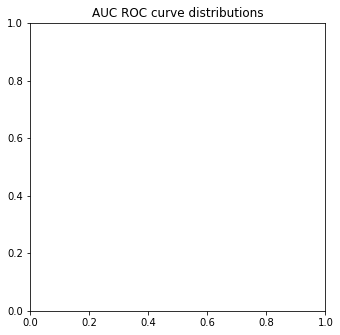

In [7]:
auc, computed = pr.predict_all(states, spaces, indices, 'inactive-active', states_future)
pr.plot_comp(auc, states, computed)

To compare the models for scientists, institutions and stations, for all transitions, we need to use the same function for every configuration:

In [ ]:
auc1, computed = pr.predict_all(scientists, spaces, indices, 'inactive-active', scientists_future)
auc2, computed = pr.predict_all(institutions, spaces, indices, 'inactive-active', institutions_future)
auc3, computed = pr.predict_all(states, spaces, indices, 'inactive-active', states_future)
auc4, computed = pr.predict_all(institutions, spaces, indices, 'nascent-developed', institutions_future)
auc5, computed = pr.predict_all(states, spaces, indices, 'nascent-developed', states_future)
auc6, computed = pr.predict_all(institutions, spaces, indices, 'intermediate-developed', institutions_future)
auc7, computed = pr.predict_all(states, spaces, indices, 'intermediate-developed', states_future)
aucs = [auc1, auc2, auc3, auc3, auc4, auc5, auc6, auc7]

aux = list()
for a in aucs:
    aux += a
aucs = aux

And here are the results:

In [ ]:
def __adj_val(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, max(vals))

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, min(vals), q1)
    return lower_adjacent_value, upper_adjacent_value

def __axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [ ]:
plt.rcParams["figure.figsize"] = (9.8,4)
ax = plt.subplot(1,1,1)
pos = np.array([1,2,4,5,7,8,11,12,14,15,18,19,21,22])/22 * 13.5 + 0.5
parts = ax.violinplot(aucs, positions=pos, showmeans=False, showmedians=True, showextrema=False, widths=0.6, points=1000)

for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    if i%2 ==0:
        pc.set_facecolor(plt.cm.viridis(0.25))
    else:
        pc.set_facecolor(plt.cm.viridis(0.99))
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)
    pc.set_zorder(2)
parts["cmedians"].set_edgecolor('black')

mean = [np.mean(x) for x in aucs]
q1, q3 = np.array([np.percentile(x, [25, 75]).tolist() for x in aucs]).T
whiskers = np.array([__adj_val(vals, qq1, qq3) for vals, qq1, qq3 in zip(aucs, q1, q3)])
wMin, wMax = whiskers[:,0], whiskers[:,1]

ax.scatter(pos, mean, marker='o', color='white', s=30, zorder=4)
ax.vlines(pos, q1, q3, color='k', linestyle='-', lw=5, zorder=3)
ax.vlines(pos, wMin, wMax, color='k', linestyle='-', lw=1, zorder=3)

plt.ylabel('AUROC')
plt.xlabel("")
plt.box(False)
plt.tight_layout()

ax.yaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
ax.yaxis.grid(zorder=0)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.text((pos[2]+pos[3])/2, -0.07, "Inactive-Active", size=12, ha='center')
plt.text((pos[7]+pos[8])/2, -0.07, "Nascent-Developed", size=12, ha='center')
plt.text((pos[11]+pos[12])/2, -.07, "Intermediate-Developed", size=12, ha='center')

plt.text((pos[0]+pos[1])/2, 1.03, "Scientists", size=10, ha='center')
plt.text((pos[2]+pos[3])/2, 1.03, "Institutions", size=10, ha='center')
plt.text((pos[4]+pos[5])/2, 1.03, "States", size=10, ha='center')

plt.text((pos[6]+pos[7])/2, 1.03, "Institutions", size=10, ha='center')
plt.text((pos[8]+pos[9])/2, 1.03, "States", size=10, ha='center')

plt.text((pos[10]+pos[11])/2, 1.03, "Institutions", size=10, ha='center')
plt.text((pos[12]+pos[13])/2, 1.03, "States", size=10, ha='center')

plt.legend(['Frequentist', 'Embedding'],bbox_to_anchor=(1.07, .95))

plt.show()

With this package, you can do multiple experiments easily. All figures in our paper were generated by running it.